# Estimating-the-correlation-length 

* A central parameter for the `DIVAnd` analysis is the correlation length
* It determines whether two points separated by a given distance are correlated or not
* `DIVAnd` includes several tools to estimate the correlation length
* We will start with a 2D case and consider the 3D case

In [1]:
using divand
using PyPlot

INFO: Recompiling stale cache file /home/abarth/.julia/lib/v0.6/divand.ji for module divand.


# Data reading
Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file is a space-separated file containing data based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

In [2]:
fname = "Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
else
    info("Data file already downloaded")
end

INFO: Data file already downloaded


Load the data

In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);

`mincount` is the minimum number of observations per distance bin and the call to [`srand`](https://docs.julialang.org/en/latest/stdlib/Random/#Random.srand) (seed for the random number generator) ensures a reproducible sequence of random numbers.

In [4]:
mincount = 100
srand(12345); # this can be any number

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* We use the function `divand.fit_isotropic`


In [5]:
?fit_isotropic

search: fit_isotropic



```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = divand.alpha_default(length(x)),
                           minlen = 0.,
                           maxlen = 10.,
                           tolrel = 1e-4,
                           maxpoints = 10000,
                           nmean = 100,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (iter,var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to  a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for for any proper 3D analysis).
  * `len`: initial value for the correlation length
  * `minlen`, `maxlen`: minimum and maximum value for the correlation length
  * `tolrel`: relative tolerance for the optimizer
  * `maxpoints`: maximum number of data points considered
  * `nmean`: the number of time an empirical covariance is estimated.  The average covariance is used for the fitting.
  * `distfun`: function to compute the distance between point `xi` (vector) and  `xj`. Per default `distun` is the Eucedian distance `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with the input parameters `iter`, `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from the `x` and `v`. It is therefore often necessary to provide reasonable values for these default parameters.

The algorithm used to estimate the correlation-length and variance is based on randomly choosen points. Therefore the result can be different if the function is invoked repeately. If `nmean` is increased, then these statistical fluctuations should decrease (for a not too large value of `mincount`, i.e. about 100 for most cases).

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


## Example 1: salinity in the Black Sea
The profiles were already vertically interpolated on standard depth levels.

INFO: Making empirical covariance
INFO: Fitting empirical covariance


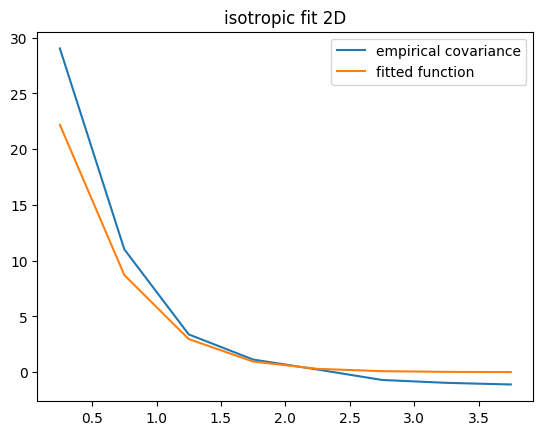

PyObject Text(0.5,1,u'isotropic fit 2D')

In [6]:
# surface values for the month January
sel = (obsdepth .< 10) .& Dates.month.(obstime) .== 1;
x = (obslon[sel],obslat[sel]);
v = obsval[sel] - mean(obsval[sel]);
distbin = 0:0.5:4

var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount)


figure()
plot(distx,covar, label = "empirical covariance")
plot(distx,fitcovar, label = "fitted function")
legend()
title("isotropic fit 2D")

The data from the file `Salinity.bigfile` is already interpolated on standard depth levels, which makes it not ideal to explore the vertical correlation.
The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the World Ocean Database for the Provençal Basin (Mediterranean Sea).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. Increasing the parameter `nmean` can make the estimation of the correlation more robust.

* Load the data file if it is not already present.
* Note we do not use the file `Salinity.bigfile` because it correspond to data already vertically interpolated which is not optimal for estimating the vertical correlation length

## Example 2: salinity in the Provençal Basin
In this case, the profiles were not interpolated vertically.

In [7]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
else
    info("Data file $filename already downloaded")
end

INFO: Data file WOD-Salinity-Provencal.nc already downloaded


Load the data and print basic information about it that can be used for quality check.

In [8]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


For this example we select only the first month (January)

In [9]:
sel = (Dates.month.(obstime) .== 1)
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500];

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [10]:
srand(1234);
@time lenxy,infoxy = fithorzlen(x,v,z, nmean = 500, distbin = collect(0.:0.1:6))

nsamp = 0


INFO: Number of data points: 86141
INFO: data mean: 9.395486443623647e-15
INFO: data variance: 0.051599138150430324
INFO: Now calculating distance distribution
INFO: Number of data couples considered: 3.71009287e9
INFO: maximum distance between points: 8.6006103921461
INFO: Mean distance between points: 2.009327833153499
INFO: Number of probable active bins: 80.0


Data points at z=0.0: 86141, correlation length: 0.14015061636245654
nsamp = 0


INFO: distance for binning: 0.025116597914418736
INFO: maximum number of bins: 343
INFO: Average number of pairs in each bin: 1.0816722858600583e7
INFO: First zero crossing: 18 0.025116597914418736 0.45209876245953723
INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.14015061636245654 0.012566352476800933
INFO: S/N: 0.32194352075405236
INFO: Relative misfit of fit: 0.06616474419112335
INFO: Number of data points: 87901
INFO: data mean: -1.69818590248067e-14
INFO: data variance: 0.05152757148732864
INFO: Now calculating distance distribution
INFO: Number of data couples considered: 3.86324895e9
INFO: maximum distance between points: 8.6006103921461
INFO: Mean distance between points: 2.0070871476442087
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.02508858934555261
INFO: maximum number of bins: 343
INFO: Average number of pairs in each bin: 1.126324460787172e7
INFO: First zero crossing: 18 0.02508858934555261 0.45159460821994696
INFO: Now tr

Data points at z=10.0: 87901, correlation length: 0.13909113933174366
nsamp = 0
Data points at z=100.0: 101834, correlation length: 0.13309045981327944
nsamp = 0


INFO: Number of data couples considered: 5.185030861e9
INFO: maximum distance between points: 8.6006103921461
INFO: Mean distance between points: 1.9946116120386579
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.024932645150483223
INFO: maximum number of bins: 345
INFO: Average number of pairs in each bin: 1.5029222544927536e7
INFO: First zero crossing: 17 0.024932645150483223 0.4238549675582148
INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.13309045981327944 0.010334484482096246
INFO: S/N: 0.2539388884101284
INFO: Relative misfit of fit: 0.06086141261947403
INFO: Number of data points: 114742
INFO: data mean: 1.7158249047812359e-15
INFO: data variance: 0.04969328820803998
INFO: Now calculating distance distribution
INFO: Number of data couples considered: 6.582805911e9
INFO: maximum distance between points: 8.6006103921461
INFO: Mean distance between points: 1.9859393101777347
INFO: Number of probable active bins: 80.0
INFO: distance for

Data points at z=200.0: 114742, correlation length: 0.12491558261017952
nsamp = 0


INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.12491558261017952 0.009159638965036417
INFO: S/N: 0.22597617321662264
INFO: Relative misfit of fit: 0.06729894923842485
INFO: Number of data points: 125816
INFO: data mean: -1.547972943598934e-14
INFO: data variance: 0.045265458400608305
INFO: Now calculating distance distribution


Data points at z=300.0: 125816, correlation length: 0.11527302097860567
nsamp = 0


INFO: Number of data couples considered: 7.91477002e9
INFO: maximum distance between points: 8.6006103921461
INFO: Mean distance between points: 1.9797856758884613
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.024747320948605767
INFO: maximum number of bins: 348
INFO: Average number of pairs in each bin: 2.2743772781609196e7
INFO: First zero crossing: 17 0.024747320948605767 0.42070445612629803
INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.11527302097860567 0.008332272668930553
INFO: S/N: 0.22560395160343646
INFO: Relative misfit of fit: 0.07449681886644634
INFO: Number of data points: 102006
INFO: data mean: -1.0052334498265943e-14
INFO: data variance: 0.02187712535872466
INFO: Now calculating distance distribution


Data points at z=400.0: 102006, correlation length: 0.0804865524601921
nsamp = 0


INFO: Number of data couples considered: 5.202561015e9
INFO: maximum distance between points: 8.26318837897349
INFO: Mean distance between points: 1.9050071588211146
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.023812589485263932
INFO: maximum number of bins: 348
INFO: Average number of pairs in each bin: 1.4950034534482758e7
INFO: First zero crossing: 13 0.023812589485263932 0.3095636633084311
INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.0804865524601921 0.0045358695799566084
INFO: S/N: 0.2615652298580144
INFO: Relative misfit of fit: 0.07525616192876722
INFO: Number of data points: 83943
INFO: data mean: -3.796417571981219e-14
INFO: data variance: 0.013991642498201137
INFO: Now calculating distance distribution


Data points at z=500.0: 83943, correlation length: 0.049804518007494226
nsamp = 0


INFO: Number of data couples considered: 3.523171653e9
INFO: maximum distance between points: 7.7461341486077036
INFO: Mean distance between points: 1.8310484561578761
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.02288810570197345
INFO: maximum number of bins: 339
INFO: Average number of pairs in each bin: 1.0392960544247787e7
INFO: First zero crossing: 17 0.02288810570197345 0.3890977969335487
INFO: Now trying to fit Bessel covariance function
INFO: Best fit: 0.049804518007494226 0.001743783093654591
INFO: S/N: 0.1423745180133132
INFO: Relative misfit of fit: 0.10913583357976163
INFO: Number of data points: 64682
INFO: data mean: -5.231137731810391e-14
INFO: data variance: 0.013097360850532636
INFO: Now calculating distance distribution


(nbmax, n, nsamp) = (377, 64682, 0)
Data points at z=700.0: 64682, correlation length: 0.10293018876516541
nsamp = 0


INFO: Number of data couples considered: 2.091848221e9
INFO: maximum distance between points: 7.7461341486077036
INFO: Mean distance between points: 1.6468830202426465
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.020586037753033082
INFO: maximum number of bins: 377
INFO: Average number of pairs in each bin: 5.548754806366048e6
INFO: First zero crossing: 5 0.020586037753033082 0.10293018876516541
INFO: Now trying to fit Bessel covariance function
INFO: Number of data points: 47423
INFO: data mean: 1.4291763362337454e-14
INFO: data variance: 0.014378020303933571
INFO: Now calculating distance distribution


(nbmax, n, nsamp) = (375, 47423, 0)
Data points at z=1000.0: 47423, correlation length: 0.09456043065581562
nsamp = 0


INFO: Number of data couples considered: 1.124446753e9
INFO: maximum distance between points: 7.0871236400831386
INFO: Mean distance between points: 1.5129668904930498
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.018912086131163124
INFO: maximum number of bins: 375
INFO: Average number of pairs in each bin: 2.998587905333333e6
INFO: First zero crossing: 5 0.018912086131163124 0.09456043065581562
INFO: Now trying to fit Bessel covariance function
INFO: Number of data points: 30885
INFO: data mean: 8.697908114256794e-15
INFO: data variance: 0.019045218645364435
INFO: Now calculating distance distribution


(nbmax, n, nsamp) = (373, 30885, 0)
Data points at z=1500.0: 30885, correlation length: 0.17847456465611988


INFO: Number of data couples considered: 4.7692617e8
INFO: maximum distance between points: 6.639537176648861
INFO: Mean distance between points: 1.427796517248959
INFO: Number of probable active bins: 80.0
INFO: distance for binning: 0.017847456465611988
INFO: maximum number of bins: 373
INFO: Average number of pairs in each bin: 1.2786638404825737e6
INFO: First zero crossing: 10 0.017847456465611988 0.17847456465611988
INFO: Now trying to fit Bessel covariance function


2533.414688 seconds (3.01 M allocations: 137.533 MiB, 0.00% gc time)


([0.135074, 0.135006, 0.131331, 0.122526, 0.107385, 0.0830853, 0.0648317, 0.0983579, 0.0968067, 0.176836], Dict{Symbol,Any}(Pair{Symbol,Any}(:fitcovar, [6.75217e-316 1.97626e-323 … 8.54985e-306 6.75431e-316; 6.27126e-316 7.05557e-316 … 1.3442e-72 0.0; … ; 6.75412e-316 6.48847e-319 … 0.0 1.6976e-313; 6.75413e-316 4.25228e-314 … 8.2791e-313 2.122e-314]),Pair{Symbol,Any}(:fitinfos, Dict{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:sn, 0.321944),Pair{Symbol,Any}(:rqual, 0.933835),Pair{Symbol,Any}(:fitcovar, [NaN, 0.0120926, 0.0112098, 0.0101884, 0.00914102, 0.00812551, 0.00717214, 0.00629562, 0.00550147, 0.00478967  …  1.48015e-27, 1.23914e-27, 1.03736e-27, 8.68438e-28, 7.27019e-28, 6.08626e-28, 5.09511e-28, 4.26535e-28, 3.57071e-28, 2.98918e-28]),Pair{Symbol,Any}(:covar, [0.0131331, 0.0119648, 0.0107077, 0.0100711, 0.00964831, 0.00890864, 0.00804018, 0.00729995, 0.00648546, 0.00549366  …  0.14253, 0.159474, 0.176565, 0.183101, 0.180855, 0.181395, 0.198267, 0.243653, 0.315605, 0.377209])

Make a plot of the horizontal correlation length with respect to the depth.

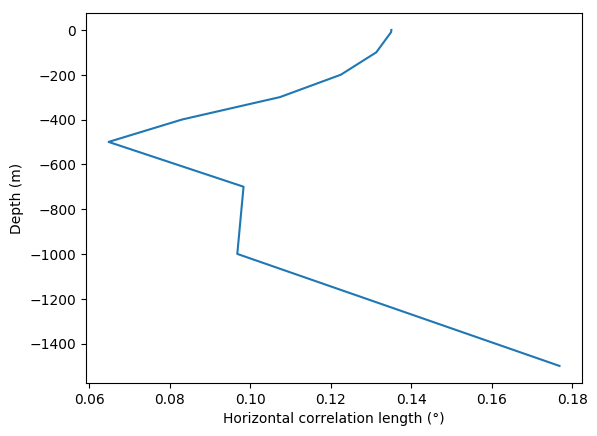

In [11]:
plot(lenxy,-z)
xlabel("Horizontal correlation length (°)")
ylabel("Depth (m)");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [12]:
srand(1234);
@time lenz,infoz = fitvertlen(x,v,z, nmean = 500, distbin = collect([0.:50:400; 500:100:600]))

INFO: Making empirical covariance
INFO: Fitting empirical covariance


Correlation length at z=0.0: 57.88478847884789


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


Correlation length at z=10.0: 57.4977497749775
Correlation length at z=100.0: 57.24572457245725
Correlation length at z=200.0: 59.64896489648965
Correlation length at z=300.0: 60.99009900990099
Correlation length at z=400.0: 60.62106210621062
Correlation length at z=500.0: 60.9000900090009
Correlation length at z=700.0: 100.0
Correlation length at z=1000.0: 100.0
Correlation length at z=1500.0: 100.0
 25.234908 seconds (875.77 M allocations: 74.556 GiB, 20.21% gc time)


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


([57.6981, 57.705, 58.0752, 59.3871, 60.5586, 61.6991, 65.8397, 96.6486, 99.9285, 99.9995], Dict{Symbol,Any}(Pair{Symbol,Any}(:fitcovar, [0.0252676 0.0251102 … 0.00256942 0.00210995; 0.0134825 0.013316 … 0.00195551 0.00160582; … ; 7.86593e-6 7.33144e-6 … 4.04489e-5 3.32157e-5; 8.86125e-7 8.12928e-7 … 1.22324e-5 1.00449e-5]),Pair{Symbol,Any}(:covar, [0.0286905 0.0285542 … 0.00269583 0.00221375; 0.0169903 0.017123 … 0.00274869 0.00172959; … ; -0.0117526 -0.0116696 … -0.000807387 0.00191609; -0.00304715 -0.00296691 … -0.00212206 0.00194721]),Pair{Symbol,Any}(:stdcovar, [0.00587401 0.00526718 … 0.00508268 0.00537369; 0.00363142 0.0039231 … 0.00442151 0.00482815; … ; 0.0048703 0.00505421 … 0.0034862 0.00343275; 0.0039996 0.00493679 … 0.00336178 0.00327033]),Pair{Symbol,Any}(:len, [57.8848, 57.4977, 57.2457, 59.649, 60.9901, 60.6211, 60.9001, 100.0, 100.0, 100.0]),Pair{Symbol,Any}(:distx, [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 450.0, 550.0]),Pair{Symbol,Any}(:var0, [0.0286905

Make a plot

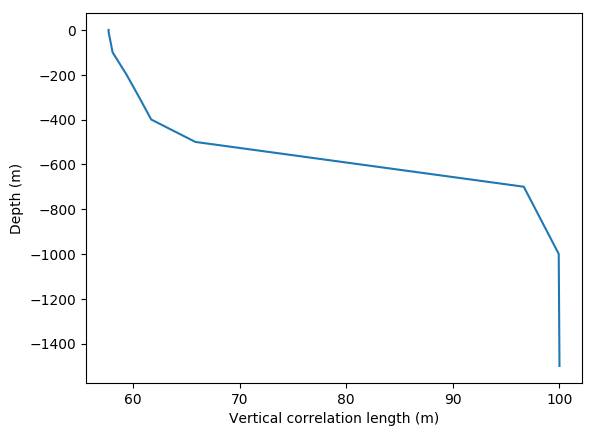

In [13]:
plot(lenz,-z)
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");